In [38]:
from osgeo import gdal
from osgeo import gdal_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv
import numpy as np
%matplotlib inline

### Import the NYC satellite image
Note it's a multi-spectral image from the Landsat 8 satellite. This is the most commonly used remote sensing imagery. It has 12 bands as listed in the table below.

In [31]:
dataset = gdal.Open('data/NYC_test.tif', gdal.GA_ReadOnly)

# How many bands does this image have?
num_bands = dataset.RasterCount
print('Number of bands in image: {n}'.format(n=num_bands))

# How many rows and columns?
rows = dataset.RasterYSize
cols = dataset.RasterXSize
print('Image size is: {r} rows x {c} columns'.format(r=rows, c=cols))

Number of bands in image: 12
Image size is: 519 rows x 623 columns


### Here are the bands in our image:

In [29]:
with open('data/table.csv', 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        print '     '.join(row)

﻿Name     Description
B1     "Band 1 (Ultra Blue) surface reflectance      0.435-0.451 μm"
B2     "Band 2 (Blue) surface reflectance      0.452-0.512 μm"
B3     "Band 3 (Green) surface reflectance      0.533-0.590 μm"
B4     "Band 4 (Red) surface reflectance      0.636-0.673 μm"
B5     "Band 5 (Near Infrared) surface reflectance      0.851-0.879 μm"
B6     "Band 6 (Shortwave Infrared 1) surface reflectance      1.566-1.651 μm"
B7     "Band 7 (Shortwave Infrared 2) surface reflectance      2.107-2.294 μm"
B10     "Band 10 brightness temperature (Kelvin)      10.60-11.19 μm"
B11     "Band 11 brightness temperature (Kelvin)      11.50-12.51 μm"
sr_aerosol     "Aerosol attributes      see Aerosol QA table"
pixel_qa     "Pixel quality attributes      see Pixel QA table"
radsat_qa     "Radiometric saturation QA      see Radsat QA table"


#### Make a dictionary of them

In [91]:
band_dict = {'B1':'Ultra blue','B2':'Blue','B3':'Green','B4':'Red','B5':'NIR','B6':'Shortwave IR 1','B7':'Shortwave IR 2','B10':'Thermal 1','B11':'Thermal 2'}
band_dict

{'B1': 'Ultra blue',
 'B10': 'Thermal 1',
 'B11': 'Thermal 2',
 'B2': 'Blue',
 'B3': 'Green',
 'B4': 'Red',
 'B5': 'NIR',
 'B6': 'Shortwave IR 1',
 'B7': 'Shortwave IR 2'}

### Show which Numpy index values go with the official band names

In [103]:
for i in range(7):
    my_key="B"+str(i+1)
    print(i, band_dict[my_key])
    
    # This needs an exception clause
    # Fix it so it shows all the bands with range(num_bands)

(0, 'Ultra blue')
(1, 'Blue')
(2, 'Green')
(3, 'Red')
(4, 'NIR')
(5, 'Shortwave IR 1')
(6, 'Shortwave IR 2')


In [32]:
# What driver was used to open the raster?
driver = dataset.GetDriver()
print('Raster driver: {d}\n'.format(d=driver.ShortName))

Raster driver: GTiff



### Load the pixel values into a Numpy array

In [39]:
# Initialize a 3d array -- size based on raster dimensions
image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount))

# Allocate array using the first band's datatype
image_datatype = dataset.GetRasterBand(1).DataType

image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                 dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))

# Loop over all bands in dataset

for b in range(dataset.RasterCount):
    # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
    band = dataset.GetRasterBand(b + 1)
    
    # Read in the band's data into the third dimension of our array
    image[:, :, b] = band.ReadAsArray()


### Inspect the bands

In [52]:
for i in range(dataset.RasterCount):
    print("Band {} has mean value {}".format(i,np.nanmean(image[:,:,i])))

print

for i in range(dataset.RasterCount):
    print("Band {} has st dev {}".format(i,np.nanstd(image[:,:,i])))


Band 0 has mean value 0.0798923522234
Band 1 has mean value 0.0884755477309
Band 2 has mean value 0.106493577361
Band 3 has mean value 0.109625801444
Band 4 has mean value 0.161938607693
Band 5 has mean value 0.150211021304
Band 6 has mean value 0.120927736163
Band 7 has mean value 0.297069817781
Band 8 has mean value 0.294333189726
Band 9 has mean value 0.00931236986071
Band 10 has mean value 0.0322430990636
Band 11 has mean value 0.0

Band 0 has st dev 0.0422568656504
Band 1 has st dev 0.0473320111632
Band 2 has st dev 0.0537671931088
Band 3 has st dev 0.0628626197577
Band 4 has st dev 0.0915726199746
Band 5 has st dev 0.0867431536317
Band 6 has st dev 0.0749443545938
Band 7 has st dev 0.00374323106371
Band 8 has st dev 0.00302697555162
Band 9 has st dev 0.00159977586009
Band 10 has st dev 0.000136648784974
Band 11 has st dev 0.0


### Create NDVI band out of the red and NIR

In [57]:
b_red = 3
b_nir = 4

ndvi = (image[:, :, b_nir] - image[:, :, b_red]) / (image[:, :, b_red] + image[:, :, b_nir])

print(ndvi)

[[ 0.21166135  0.21166135  0.42605364 ...  0.75779814  0.7599498
   0.74625933]
 [ 0.5619275   0.5619275   0.58352405 ...  0.7659447   0.76380366
   0.7526617 ]
 [ 0.53753984  0.53753984  0.599688   ...  0.76157916  0.75359803
   0.72305566]
 ...
 [-0.43237248 -0.40796018 -0.44949493 ...  0.22370231  0.09607055
   0.09607055]
 [-0.42316782 -0.45853657 -0.5        ...  0.14798062  0.16966793
   0.16966793]
 [-0.42718446 -0.45958427 -0.4847775  ...  0.19911137  0.26304382
   0.26304382]]


### Example plot: scatter of red vs infrared values for 30m pixels of the city

Text(0.5,1,'Red versus near infrared')

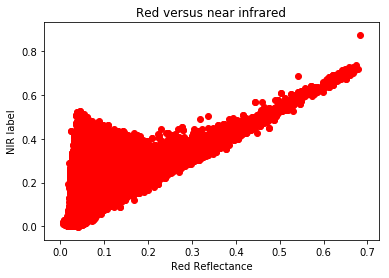

In [61]:
red = np.ndarray.flatten(image[:, :, 3])
nir = np.ndarray.flatten(image[:, :, 4])

# Make the plot
plt.scatter(red, nir, color='r', marker='o')

# Add some axis labels
plt.xlabel('Red Reflectance')
plt.ylabel('NIR label')

# Add a title
plt.title('Red versus near infrared')

### Visualize the individual bands
Write a loop to plot them all

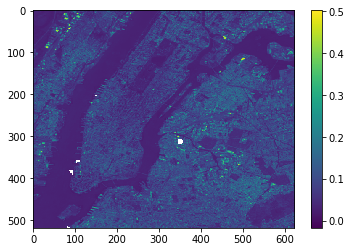

In [80]:
plt.imshow(image[:,:,0])
plt.colorbar()

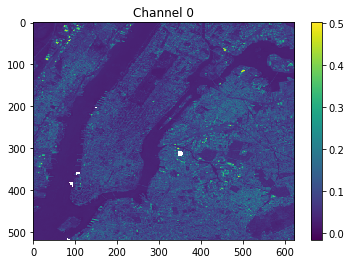

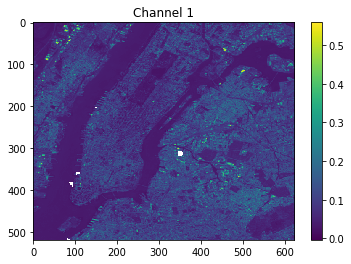

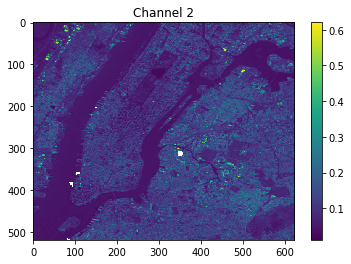

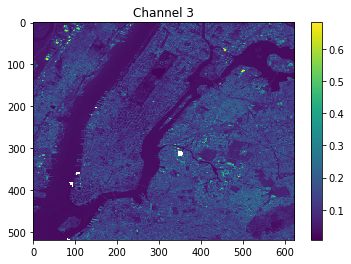

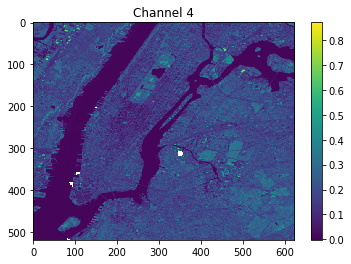

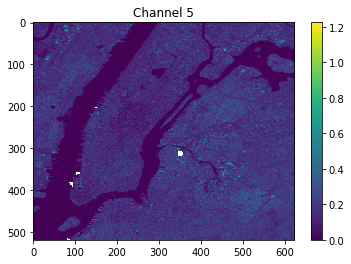

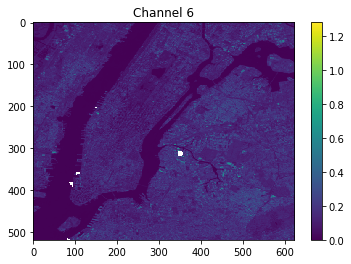

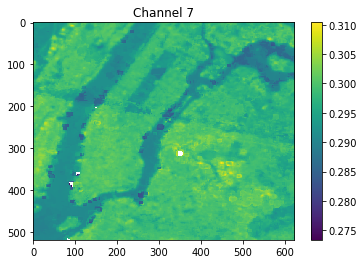

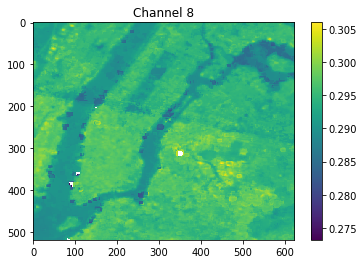

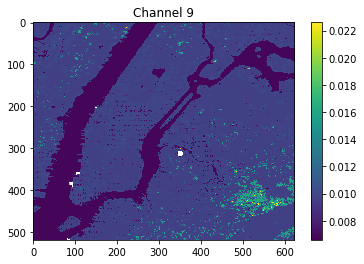

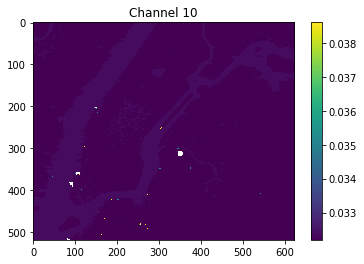

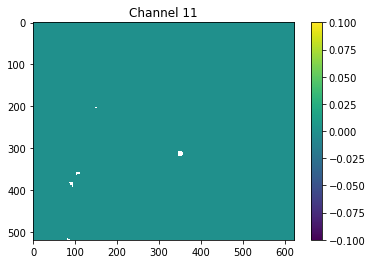

In [118]:
for i in range(num_bands):

    plt.figure()
    plt.title("Channel "+str(i)) # fix dict code then add proper band names
    plt.imshow(image[:,:,i])
    plt.colorbar()
    plt.show()

### Visualize the NDVI
See the high-vegetation parts of the city stand out

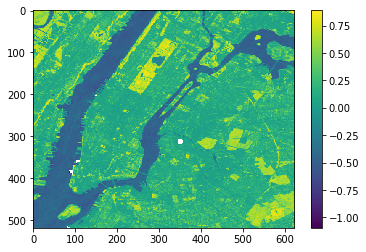

In [73]:
plt.imshow(ndvi)
plt.colorbar()

### Histogram of the bands

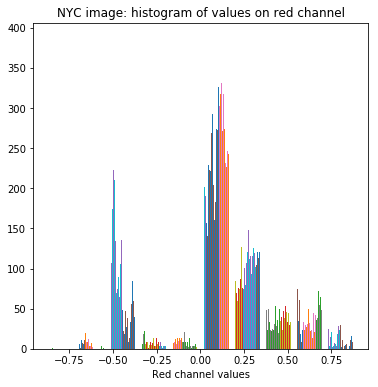

In [77]:
plt.figure(figsize = [6,6])
plt.hist(ndvi)
plt.xlabel("Red channel values")
plt.title("NYC image: histogram of values on red channel");

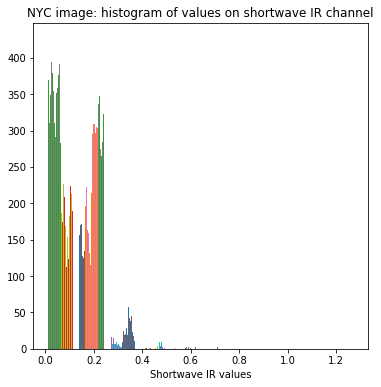

In [104]:
plt.figure(figsize = [6,6])
plt.hist(image[:,:,6])
plt.xlabel("Shortwave IR values")
plt.title("NYC image: histogram of values on shortwave IR channel");

## Histogram for each channel shows their individual 'signatures'
Also shows which part of the spectrum to zoom in on if you want to see most detail.

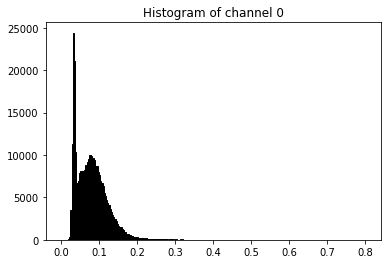

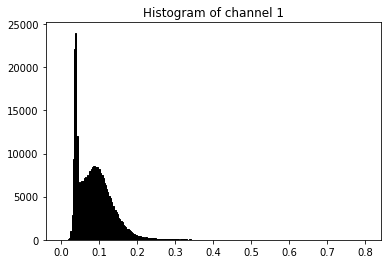

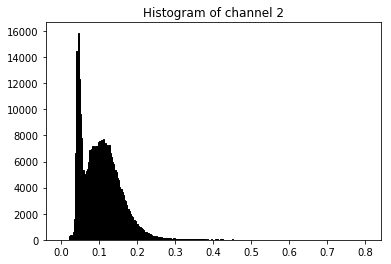

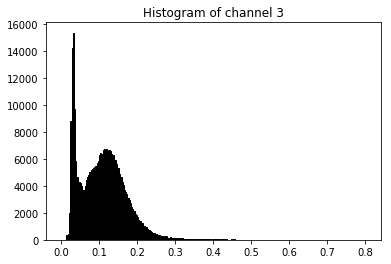

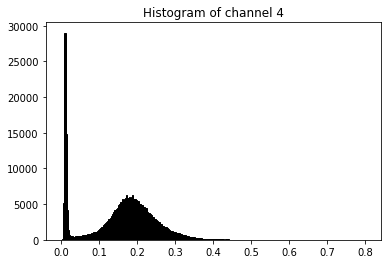

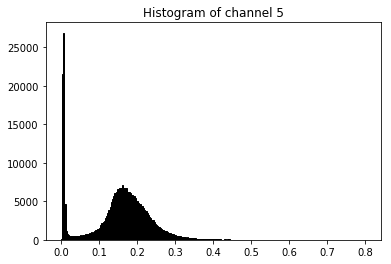

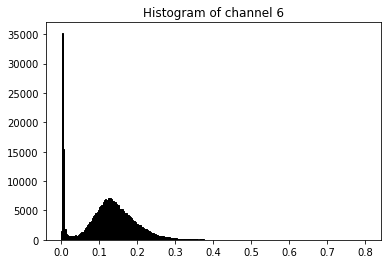

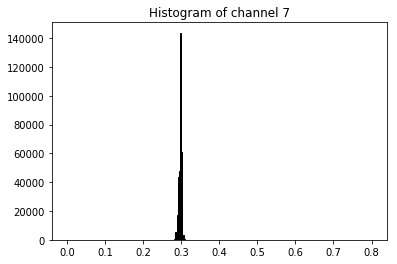

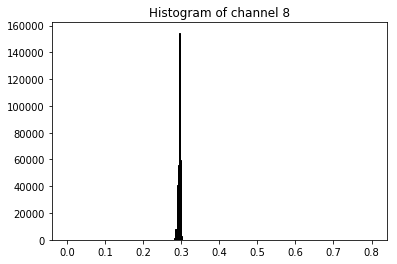

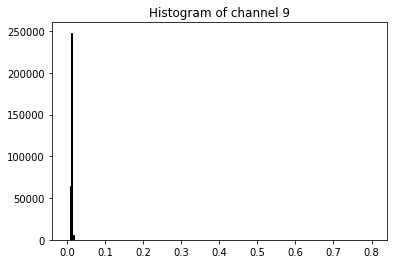

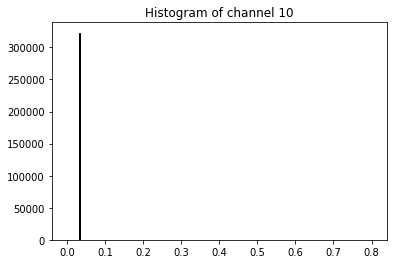

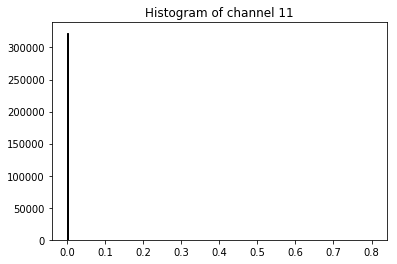

In [122]:
 for i in range(num_bands):
        plt.figure()
        plt.hist(image[:,:,i].ravel(),  range=(0.0, 0.8), bins=256, fc='k', ec='k');
        plt.title('Histogram of channel {}'.format(i))
        plt.show()

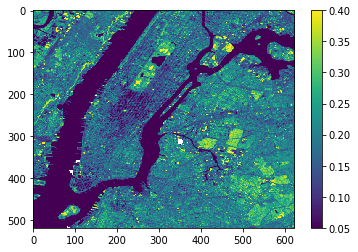

In [121]:
# Using the histogram info above channel 4 above, plot channel 4 (near infrared)
# in the range 0.05 - 0.04. Much more detail highlighted.

plt.imshow(image[:,:,4],clim=(0.05,0.4))
plt.colorbar()